In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
import re 
import string
import tensorflow as tf 
from tensorflow import keras as tfk 
from tensorflow.keras import layers as tfkl
import os, sys, pathlib, watermark
from IPython.display import Image
pd.set_option('display.max_rows', 11)
pd.set_option('display.max_columns', 15)
plt.rcParams['figure.figsize'] = (7,5)
data_train_features_path = 'train_features.npy'
data_train_labels_path = 'train_labels.npy'
data_test_features_path = 'test_features.npy'
data_test_labels_path = 'test_labels.npy'
model_path = "model.keras"  
embedding_model_weights_path = "embedding_model.weights.h5"

2025-03-13 09:24:14.738527: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-13 09:24:15.061763: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-13 09:24:15.362179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741872255.631373     324 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741872255.706933     324 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-13 09:24:16.365709: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
print("python", sys.version.split("|")[0], "\n")

assert 'pandas' in sys.modules and "pd" in locals()
print(watermark.watermark(packages = "pandas"))

assert 'numpy' in sys.modules and "np" in locals()
print(watermark.watermark(packages = "numpy"))

assert 'sklearn' in sys.modules and "cosine_similarity" in locals()
print(watermark.watermark(packages = "sklearn"))

assert 'tensorflow' in sys.modules and "tf" in locals()
print(watermark.watermark(packages = "tensorflow"))


python 3.11.11  

pandas: 2.2.3

numpy: 2.0.2

sklearn: 1.6.1

tensorflow: 2.18.0



In [3]:
data_train_features = tf.convert_to_tensor(np.load(data_train_features_path), tf.string)
data_train_labels = tf.convert_to_tensor(np.load(data_train_labels_path), tf.int32)
data_test_features = tf.convert_to_tensor(np.load(data_test_features_path), tf.string)
data_test_labels = tf.convert_to_tensor(np.load(data_test_labels_path), tf.int32)

data_train_features[:5]

2025-03-13 09:24:26.149168: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.',
       b'Reuters - Major League Baseball\\Monday announced a decision on the appeal filed by Chicago Cubs\\pitcher Kerry Wood regarding a suspension stemming from an\\incident earlier this season.',
       b'President Bush #39;s  quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.',
       b'Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.',
       b'London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria

In [4]:
numbers_to_categories = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
categories_to_numbers = {v: k for k, v in numbers_to_categories.items()}

In [5]:
number_world_articles = np.sum(data_train_labels == categories_to_numbers['World'])
number_sports_articles = np.sum(data_train_labels == categories_to_numbers['Sports'])
number_business_articles = np.sum(data_train_labels == categories_to_numbers['Business'])
number_scitech_articles = np.sum(data_train_labels == categories_to_numbers['Sci/Tech'])
print(f"World: {number_world_articles}, Sports: {number_sports_articles}, Business: {number_business_articles}, Sci/Tech: {number_scitech_articles}")


World: 9065, Sports: 8979, Business: 9001, Sci/Tech: 8955


In [6]:
word_counts = [
    len(text.numpy().decode("utf-8").split(" "))
    for text in data_train_features
]
median_length = int(np.median(word_counts))
median_length

31

In [7]:
input_text = tfkl.Input(shape = (1,), dtype = tf.string, name = "input_text")

In [8]:
VOCABULARY_SIZE = 7500
SEQUENCE_LENGTH = 50

tokenizer_layer = tfkl.TextVectorization(standardize='lower_and_strip_punctuation',
                                        max_tokens=VOCABULARY_SIZE,
                                        output_mode="int",
                                        split='whitespace',
                                        output_sequence_length=SEQUENCE_LENGTH)

tokenizer_layer.adapt(data_train_features)
input_tokens = tokenizer_layer(input_text)

In [9]:
# token and position embeddings

EMBEDDING_DIMENSION = 32
token_embedding_layer = tfkl.Embedding(input_dim=VOCABULARY_SIZE, output_dim=EMBEDDING_DIMENSION, name = "token_embedding")
embedded_tokens = token_embedding_layer(input_tokens)
position_embedding_layer = tfkl.Embedding(input_dim=SEQUENCE_LENGTH, output_dim=EMBEDDING_DIMENSION, name = "position_embedding")
positions = tf.range(start=0, limit=SEQUENCE_LENGTH, delta=1)
positions = tf.expand_dims(positions, 0)
embedded_positions = position_embedding_layer(positions)

embedded_tokens_and_positions = tfkl.Add(name = "addition_token_position")([embedded_tokens, embedded_positions])

In [10]:
# transformer
DROP_OUT_RATE = 0.1
# attention block 
attention_layer = tfkl.Attention(name = "attention")
context_adjusted_embeddings = attention_layer([embedded_tokens_and_positions, embedded_tokens_and_positions, embedded_tokens_and_positions],  return_attention_scores = False)
context_adjusted_embeddings = tfkl.Dropout(DROP_OUT_RATE, name = "attention_dropout")(context_adjusted_embeddings)
context_adjusted_embeddings = tfkl.Add(name = "attention_addition")([embedded_tokens_and_positions, context_adjusted_embeddings])
context_adjusted_embeddings = tfkl.LayerNormalization(epsilon=1e-6, name = "atttention_normalization")(context_adjusted_embeddings)


In [11]:
# transformer
FEED_FORWARD_UNITS = 64 

# feedbforward block
feed_forward_layer = tfk.Sequential([tfkl.Dense(FEED_FORWARD_UNITS, activation="relu"), 
                                     tfkl.Dense(EMBEDDING_DIMENSION, activation = "linear")], 
                                     name = "feed_forward")
transformed_context_adjusted_embeddings = feed_forward_layer(context_adjusted_embeddings)
transformed_context_adjusted_embeddings = tfkl.Dropout(DROP_OUT_RATE, name = "feed_forward_dropout")(transformed_context_adjusted_embeddings)
transformed_context_adjusted_embeddings = tfkl.Add(name = "feed_forward_addition")([context_adjusted_embeddings, transformed_context_adjusted_embeddings])
transformed_context_adjusted_embeddings = tfkl.LayerNormalization(epsilon=1e-6, name = "feed_forward_normalization")(transformed_context_adjusted_embeddings)


In [12]:
pooled_context_adjusted_embeddings = tfkl.GlobalAveragePooling1D(name = "pooling_layer")(transformed_context_adjusted_embeddings)


In [13]:
# logisitic regression
logits = tfkl.Dropout(DROP_OUT_RATE, name = "logistic_regression_dropout_1")(pooled_context_adjusted_embeddings)
logits = tfkl.Dense(16, activation="relu", name = "hidden_layer")(logits)
logits = tfkl.Dropout(DROP_OUT_RATE, name = "logistic_regression_dropout_2")(logits)
number_of_outputs = 4 
output_probabilities = tfkl.Dense(number_of_outputs, activation="softmax")(logits)

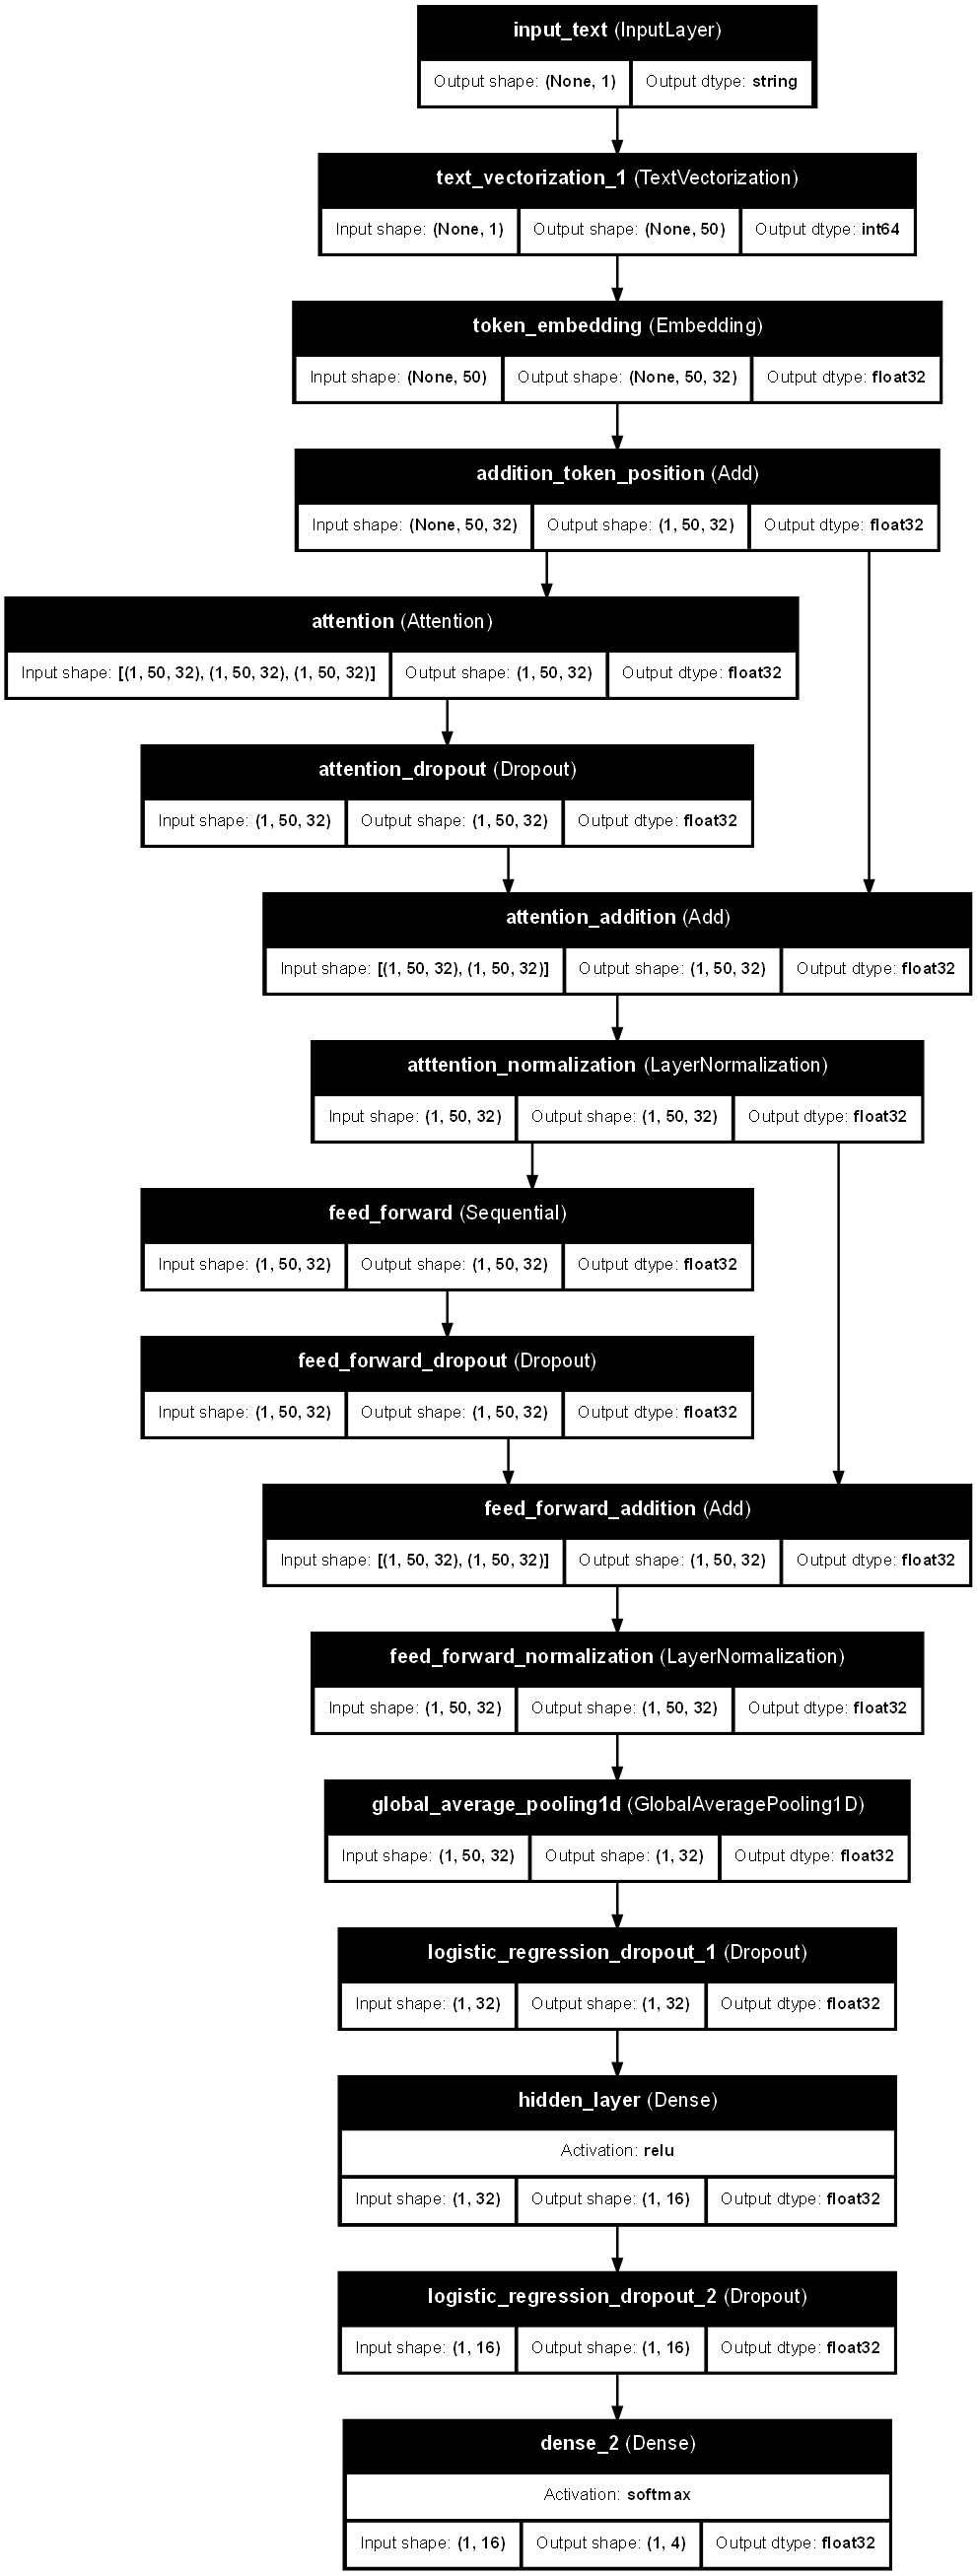

In [14]:
model = tfk.Model(inputs=input_text, outputs=output_probabilities)
Image("model.png", width = 400)

In [15]:
model = tfk.models.load_model(model_path)

In [16]:
# evaluation on test dataset 
predicted_probabilities = model.predict(data_test_features)
predicted_category = tf.argmax(predicted_probabilities, axis=1)

143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


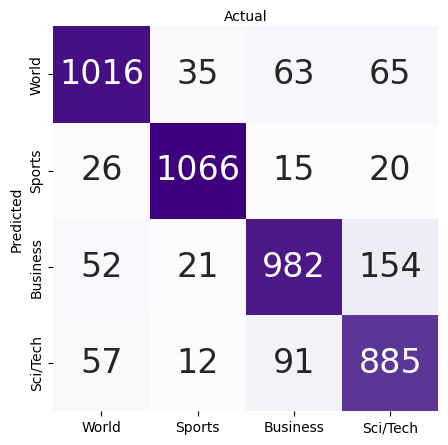

In [17]:
confusion_matrix_test_dataset = confusion_matrix(y_true = data_test_labels.numpy(), y_pred = predicted_category.numpy())
confusion_matrix_test_dataset = confusion_matrix_test_dataset.T

sns.heatmap(confusion_matrix_test_dataset, 
            annot=True, 
            fmt='d', 
            cmap="Purples", 
            annot_kws={'fontsize': 24}, 
            square=True,
            xticklabels=['World', 'Sports', 'Business', 'Sci/Tech'], 
            yticklabels=['World', 'Sports', 'Business', 'Sci/Tech'], 
            cbar=False)

plt.gca().xaxis.set_label_position('top')
plt.xlabel('Actual')
plt.ylabel('Predicted');

In [18]:
confusion_matrix_test_dataset.diagonal().sum() / confusion_matrix_test_dataset.sum()

np.float64(0.8660087719298246)

In [19]:
category_precisions = confusion_matrix_test_dataset.diagonal() / confusion_matrix_test_dataset.sum(axis=0)
macro_averaged_precision = category_precisions.mean() 
macro_averaged_precision

np.float64(0.8658209158219851)

In [20]:
category_recalls = confusion_matrix_test_dataset.diagonal() / confusion_matrix_test_dataset.sum(axis=1)
macro_averaged_recall = category_recalls.mean()
macro_averaged_recall

np.float64(0.8666881798183268)

In [21]:
sentence_embedding_layer = model.get_layer("pooling_layer") 
sentence_embedding_model = tfk.Model(inputs = model.input, outputs = sentence_embedding_layer.output) 

In [22]:
sentences = ["Here We Go Then, You And I is a 1999 album by Norwegian pop artist Morten Abel. It was Abel's second CD as a solo artist.",
              'The album went straight to number one on the Norwegian album chart, and sold to double platinum.',
              'Among the singles released from the album were the songs "Be My Lover" and "Hard To Stay Awake".',
              'Riccardo Zegna is an Italian jazz musician.',
              'Rajko Maksimovic is a composer, writer, and music pedagogue.',
              'One of the most significant Serbian composers of our time, Maksimovic has been and remains active in creating works for different ensembles.',
              'A solar eclipse occurs when the Moon passes between Earth and the Sun, thereby totally or partly obscuring the image of the Sun for a viewer on Earth.',
              "A partial solar eclipse occurs in the polar regions of the Earth when the center of the Moon's shadow misses the Earth."]

sentence_embeddings = sentence_embedding_model.predict(tf.constant(sentences, shape = (len(sentences), 1)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


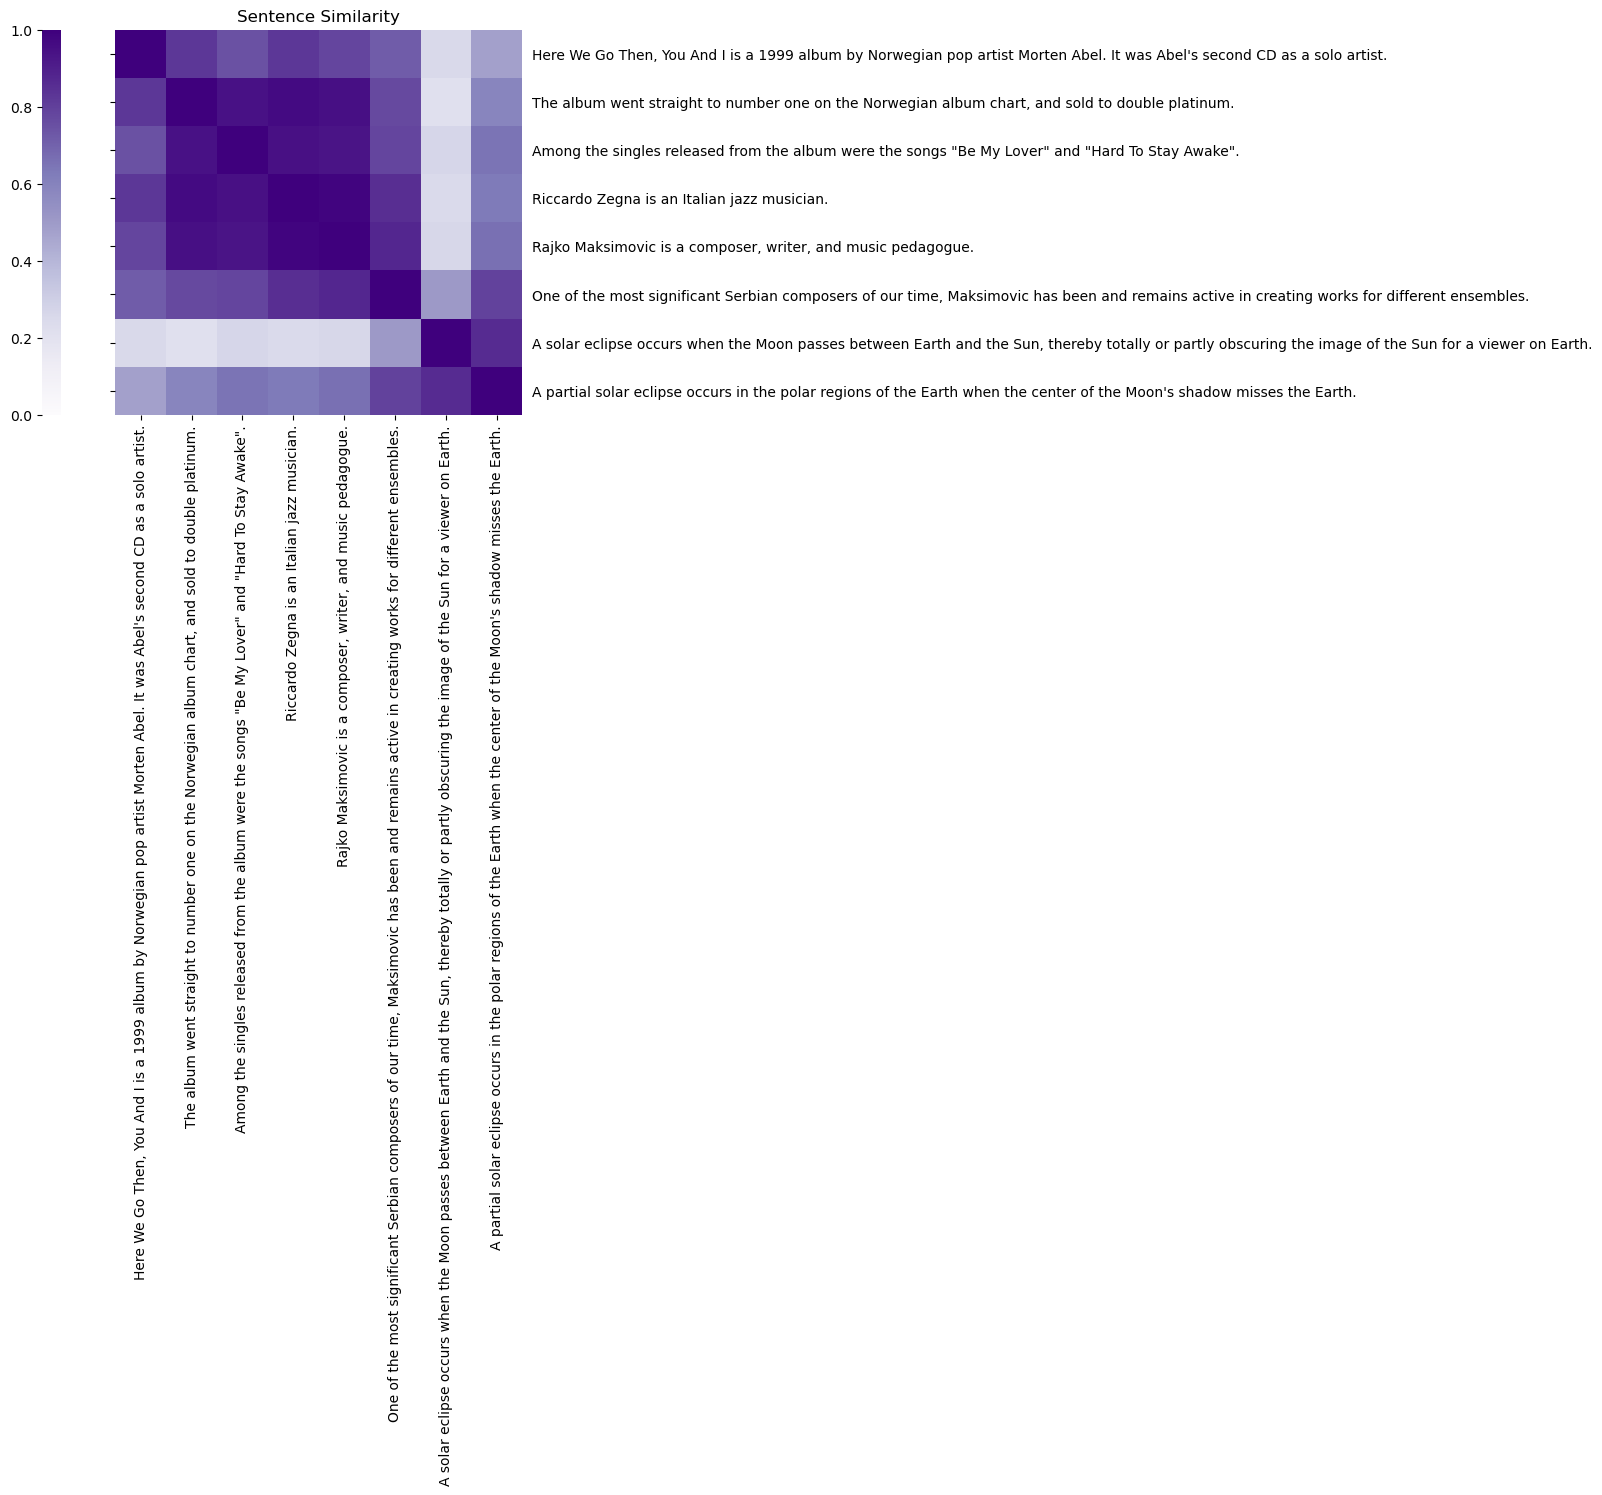

In [23]:
cosine_similarity_sentence_embeddings = cosine_similarity(sentence_embeddings)

figure = sns.heatmap(cosine_similarity_sentence_embeddings, 
                xticklabels=sentences, 
                yticklabels=sentences,
                vmin=0, vmax=1,
                cmap="Purples", 
                cbar_kws={'location': 'left'})

figure.tick_params(labelright=True, labelleft=False)
figure.set_yticklabels(sentences, rotation=0)

plt.title("Sentence Similarity");

In [24]:
word_embedding_1_layer = model.get_layer("token_embedding")  
word_embedding_2_layer = model.get_layer("addition_token_position") 
word_embedding_3_layer = model.get_layer("atttention_normalization")
word_embedding_1_model = tfk.Model(inputs = model.input, outputs = word_embedding_1_layer.output) 
word_embedding_2_model = tfk.Model(inputs = model.input, outputs = word_embedding_2_layer.output)
word_embedding_3_model = tfk.Model(inputs = model.input, outputs = word_embedding_3_layer.output)

In [27]:
# comparison 1 | sentence 2 and setence 3
embedding_of_river_bank = word_embedding_3_model(tf.constant([["located at the river bank"]]))[0,4,:]
embedding_of_commercial_bank = word_embedding_3_model(tf.constant([["located at the commercial bank"]]))[0,4,:]
cosine_similarity_river_bank_commercial_bank = cosine_similarity(
    embedding_of_river_bank.numpy().reshape(1, -1), 
    embedding_of_commercial_bank.numpy().reshape(1, -1)
)[0, 0]
cosine_similarity_river_bank_commercial_bank

np.float32(0.9999681)

In [28]:
# comparison 2 | sentence 2 and sentence 4
embedding_of_river_bank = word_embedding_2_model(tf.constant([["located at the river bank"]]))[0,4,:]
embedding_of_river_bank_different_order = word_embedding_2_model(tf.constant([["bank located at the river"]]))[0,0,:]
cosine_similarity_river_bank = cosine_similarity(
    word_embedding_2_model(tf.constant([["located at the river bank"]]))[0,4,:].numpy().reshape(1, -1),
    word_embedding_2_model(tf.constant([["bank located at the river"]]))[0,0,:].numpy().reshape(1, -1)
)[0,0]
cosine_similarity_river_bank

np.float32(0.98157656)

In [29]:
# comparison 3 | sentence 1 and sentence 4
embedding_of_bank = word_embedding_1_model(tf.constant([["bank"]]))[0,0,:]
embedding_of_river_bank_different_order = word_embedding_3_model(tf.constant([["bank located at the river"]]))[0,0,:]
cosine_similarity_bank = cosine_similarity(
    word_embedding_1_model(tf.constant([["bank"]]))[0,0,:].numpy().reshape(1, -1),
    word_embedding_3_model(tf.constant([["bank located at the river"]]))[0,0,:].numpy().reshape(1, -1)
)[0,0]
cosine_similarity_bank

np.float32(0.9019844)

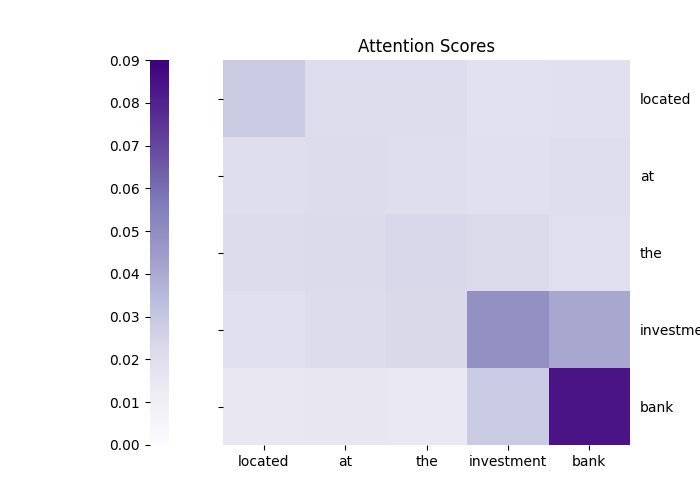

In [30]:
Image("attention_scores.png", width = 500)

In [31]:
embedding_of_four_words = word_embedding_1_model(tf.constant([["woman"], ["man"], ["king"], ["queen"]]))
embedding_of_woman, embedding_of_man, embedding_of_king, embedding_of_queen = embedding_of_four_words[0,0,:], embedding_of_four_words[1,0,:], embedding_of_four_words[2,0,:], embedding_of_four_words[3,0,:]

In [32]:
king_minus_man_plus_woman = embedding_of_king - embedding_of_man + embedding_of_woman
king_and_queen_similarity = cosine_similarity(
    king_minus_man_plus_woman.numpy().reshape(1, -1),
    embedding_of_queen.numpy().reshape(1, -1)
)[0, 0]
king_and_queen_similarity

np.float32(0.8087584)

In [33]:
embedding_of_street = word_embedding_1_model(tf.constant([["street"]]))[0, 0, :]

street_and_queen_similarity = cosine_similarity(
    embedding_of_queen.numpy().reshape(1, -1),
    embedding_of_street.numpy().reshape(1, -1)
)[0, 0]

street_and_queen_similarity

np.float32(-0.504103)

In [34]:
# input 
input_text_new = tfkl.Input(shape = (1,), dtype = tf.string, name = "input_text_new")
input_tokens_new = tokenizer_layer(input_text_new)
# token and position embeddings
embedded_tokens_new = token_embedding_layer(input_tokens_new)
rounding_layer = tfkl.Lambda(lambda x: tf.where(x > 0.0, 1.0, 0.0), output_shape=(SEQUENCE_LENGTH, EMBEDDING_DIMENSION), name = "rounding_layer")
embedded_tokens_new = rounding_layer(embedded_tokens_new)
# embedding model
binary_embedding_model = tfk.Model(inputs = [input_text_new], outputs = [embedded_tokens_new])
binary_embedding_model.load_weights(embedding_model_weights_path)
binary_embedding_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_text_new (InputLayer)     │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 50)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_embedding (Embedding)     │ (None, 50, 32)         │       240,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rounding_layer (Lambda)         │ (None, 50, 32)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,000 (937.50 KB)

 Trainable params: 240,000 (937.50 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
binary_embedding_of_bank = binary_embedding_model.predict(tf.constant(["bank"]))
binary_embedding_of_bank = binary_embedding_of_bank[0, 0, :]
binary_embedding_of_bank = binary_embedding_of_bank[:32]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


/opt/conda/envs/mggy8423/lib/python3.11/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_text_new']
Received: inputs=Tensor(shape=(1,))
  warnings.warn(msg)


In [37]:
def hamming_distance(embedding_1, embedding_2):
    sum_of_logical_xor = np.sum(np.logical_xor(embedding_1, embedding_2))
    return sum_of_logical_xor
embedding_of_microsoft = binary_embedding_model.predict(tf.constant(["microsoft"]))[0,0,:]
embedding_of_samsung = binary_embedding_model.predict(tf.constant(["samsung"]))[0,0,:]

assert hamming_distance(embedding_of_microsoft, embedding_of_samsung) == 17

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [38]:
embedding_matrix = binary_embedding_model.get_layer("token_embedding").get_weights()[0]
embedding_matrix

array([[ 0.02638542, -0.01356412, -0.03381678, ..., -0.03713739,
         0.04703692, -0.01262362],
       [ 0.04927022,  0.01307303,  0.01966109, ..., -0.03323339,
         0.02560705, -0.00347171],
       [-0.02407078, -0.00903761,  0.01545406, ...,  0.03717839,
        -0.01597009,  0.04132351],
       ...,
       [-0.04837511,  0.03669468,  0.00404699, ..., -0.02239577,
         0.04532428, -0.03959448],
       [-0.0094862 , -0.04940581, -0.01045666, ...,  0.03635014,
        -0.03613799, -0.00048633],
       [-0.00219484, -0.02031268,  0.01389501, ...,  0.01126911,
        -0.03414898,  0.00884533]], dtype=float32)

In [40]:
def reverse_embedding(vector):
    distances = np.linalg.norm(embedding_matrix - vector, axis = 1)
    index_of_closest_vector = np.argmin(distances)
    word_from_token =  tokenizer_layer.get_vocabulary()[index_of_closest_vector]
    return word_from_token

embedding_of_microsoft = binary_embedding_model.predict(tf.constant(["microsoft"]))[0,0,:]

embedding_of_microsoft[6] = 1.0 - embedding_of_microsoft[6]
assert reverse_embedding(embedding_of_microsoft) == "msft"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [41]:
embedding_of_samsung = binary_embedding_model.predict(tf.constant(["samsung"]))[0, 0, :]
embedding_of_samsung[5] = 1.0 - embedding_of_samsung[5]
reverse_embedding_of_modifed_samsung = reverse_embedding(embedding_of_samsung)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
